In [ ]:
import numpy as np
import pandas as pd

import re
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/df_full.csv")
df.head(10)

,ID,Price,Price per sqm,Rooms,Area_total,Kitchen_area,Storeys,District ID,Latitude,Longitude,...,distance_to_nearest_metro_stations_m,sports_centers_count,supermarkets_count,schools_count,kindergartens_count,cafes_restaurants_count,public_transport_count,distance_to_nearest_woods_parks_m,distance_to_nearest_water_reservoirs_m,Floor
0,1.846641e+09,2914538.0,45551.0,1.0,64.0,18.0,25.0,10026800,50.376064,30.540911,...,3192.1,1,2,0,2,3,2,214.2,356.6,22
1,1.908758e+09,5620894.0,61081.0,3.0,92.0,12.0,24.0,10026800,50.375561,30.541858,...,3214.3,1,1,1,2,2,1,208.1,375.0,19
2,1.902534e+09,3580718.0,44635.0,2.0,80.2,11.6,25.0,10026800,50.378335,30.540408,...,2983.4,0,2,0,1,3,2,249.6,240.7,24
3,1.778666e+09,2456539.0,48174.0,1.0,51.0,12.0,25.0,10026800,50.382096,30.540510,...,2619.1,0,0,0,0,0,0,143.1,441.3,19
4,1.726124e+09,1207452.0,31103.0,1.0,38.8,13.6,23.0,10026800,50.376325,30.540141,...,3190.3,1,2,0,1,3,2,249.0,368.8,17
5,1.005654e+09,3955444.0,43011.0,3.0,92.0,11.2,24.0,10026800,50.376064,30.540911,...,3192.1,1,2,0,2,3,2,214.2,356.6,8
6,1.980452e+09,3539082.0,41637.0,2.0,85.0,13.0,23.0,10026800,50.377263,30.539058,...,3128.4,1,3,0,1,3,3,308.6,370.0,22
7,1.482457e+09,2452376.0,37140.0,3.0,66.0,7.2,10.0,10026800,50.388614,30.548218,...,1714.4,0,0,0,0,0,0,654.8,1340.1,1
8,1.941193e+09,3497445.0,47924.0,2.0,73.0,12.0,24.0,10026800,50.378335,30.540408,...,2983.4,0,2,0,1,3,2,249.6,240.7,1
9,1.875529e+09,2081813.0,69866.0,1.0,29.8,13.0,27.0,10026800,50.378238,30.541067,...,2970.9,0,2,0,1,3,2,204.7,197.3,27


delete outliers to check the effect

In [ ]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


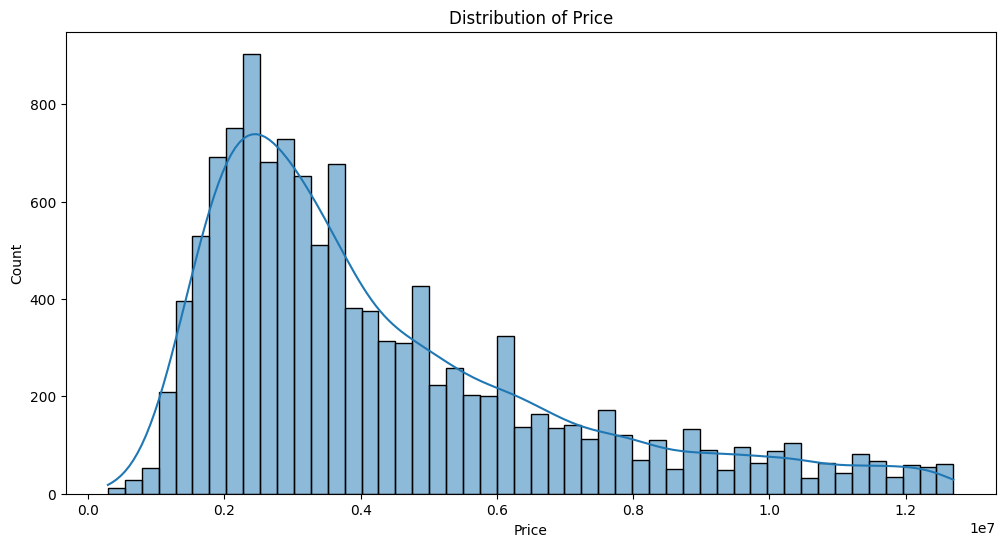

count    1.217400e+04
mean     4.307157e+06
std      2.635278e+06
min      2.914540e+05
25%      2.373267e+06
50%      3.486250e+06
75%      5.579258e+06
max      1.269906e+07
Name: Price, dtype: float64


In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='Price', kde=True, bins=50)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Count')

plt.show()

# Print summary statistics
print(df['Price'].describe())

Lets apply baseline model and also linear regression to the Log_Price as target

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# Define target column and grouping features
target_column = 'Price'  # Use original Price
district_column = 'District ID'
rooms_column = 'Rooms'
area_column = 'Area_total'

# Prepare KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics
mae_original_list = []
mape_list = []

# Loop over each fold
for fold, (train_index, test_index) in enumerate(kf.split(df), 1):
    # Split into train and test sets with .copy() to avoid SettingWithCopyWarning
    train_data = df.iloc[train_index].copy()
    test_data = df.iloc[test_index].copy()

    # Step 1: Calculate the mean Price grouped by District ID and Rooms using training data
    mean_price = (
        train_data.groupby([district_column, rooms_column])[target_column]
        .mean()
        .reset_index()
        .rename(columns={target_column: 'Mean_Price'})
    )

    # Step 2: Calculate the mean Area_total grouped by District ID and Rooms using training data
    mean_area = (
        train_data.groupby([district_column, rooms_column])[area_column]
        .mean()
        .reset_index()
        .rename(columns={area_column: 'Mean_Area'})
    )

    # Merge mean_price and mean_area to compute Price per Sqm
    mean_group = mean_price.merge(mean_area, on=[district_column, rooms_column])

    # Step 3: Calculate Price per Sqm for each group
    mean_group['Price_per_Sqm'] = mean_group['Mean_Price'] / mean_group['Mean_Area']

    # Step 4: Merge Price_per_Sqm into test set based on District ID and Rooms
    test_data = test_data.merge(mean_group[[district_column, rooms_column, 'Price_per_Sqm']],
                                on=[district_column, rooms_column],
                                how='left')

    # Handle missing groups by imputing with the overall Price per Sqm from training data
    overall_price_per_sqm = train_data[target_column].sum() / train_data[area_column].sum()
    test_data['Price_per_Sqm'] = test_data['Price_per_Sqm'].fillna(overall_price_per_sqm)

    # Predict Price in the test set
    test_data['Predicted Price'] = test_data['Price_per_Sqm'] * test_data[area_column]

    # Calculate MAE on original price scale
    mae_original = mean_absolute_error(test_data[target_column], test_data['Predicted Price'])
    mae_original_list.append(mae_original)

    # Calculate Mean Absolute Percentage Error (MAPE)
    # To avoid division by zero, add a small epsilon where Actual Price is zero
    epsilon = 1e-10
    mape = np.mean(
        np.abs((test_data[target_column] - test_data['Predicted Price']) / (test_data[target_column] + epsilon))
    ) * 100
    mape_list.append(mape)

    print(f"Fold {fold} - Baseline Validation MAE (Original Scale): {mae_original:.2f}")
    print(f"Fold {fold} - aseline Validation MAPE: {mape:.2f}%\n")

# Calculate the average MAE and MAPE over all folds
average_mae_original = np.mean(mae_original_list)
average_mape = np.mean(mape_list)

print(f"Average Baseline Validation MAE (Original Scale): {average_mae_original:.2f}")
print(f"Average Baseline Validation MAPE: {average_mape:.2f}%")

Fold 1 - Baseline Validation MAE (Original Scale): 979811.61
Fold 1 - aseline Validation MAPE: 24.09%

Fold 2 - Baseline Validation MAE (Original Scale): 1013120.51
Fold 2 - aseline Validation MAPE: 25.63%

Fold 3 - Baseline Validation MAE (Original Scale): 976119.12
Fold 3 - aseline Validation MAPE: 23.93%

Fold 4 - Baseline Validation MAE (Original Scale): 950865.23
Fold 4 - aseline Validation MAPE: 24.30%

Fold 5 - Baseline Validation MAE (Original Scale): 959811.77
Fold 5 - aseline Validation MAPE: 23.73%

Average Baseline Validation MAE (Original Scale): 975945.65
Average Baseline Validation MAPE: 24.34%






---

Lets try running linear regression using basic features scraped from the ads..



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [ ]:
# Turn "Renovation state" from bool to int
df['Renovation State'] = df['Renovation State'].apply(lambda x: 1 if x == "З ремонтом" else 0)

# Modify 'Construction Year' to represent the age of the building
df['Building_Age'] = 2024 - df['Construction Year']

In [ ]:


# Define the categorical and numerical features
categorical_features = ['District ID', 'Construction Type']
numerical_features = ['Rooms', 'Area_total', 'Kitchen_area', 'Storeys', 'Floor', 'Renovation State', 'Building_Age']

# Define target variable as Log_Price (log-transformed Price)
y = np.log(df['Price'])  # Log transform the Price
X = df[categorical_features + numerical_features]

# Preprocessor for handling categorical features (One-Hot Encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as they are
)

# Set up the linear regression model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Prepare KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store training and validation MAE
train_maes = []
val_maes = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    # Split into train and validation sets with .copy() to avoid SettingWithCopyWarning
    X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
    y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Predict on training and validation data (Log_Price predictions)
    y_train_pred_log = model.predict(X_train)
    y_val_pred_log = model.predict(X_val)

    # Inverse transform log predictions and actuals back to original price scale
    y_train_pred = np.exp(y_train_pred_log)
    y_val_pred = np.exp(y_val_pred_log)
    y_train_real = np.exp(y_train)
    y_val_real = np.exp(y_val)

    # Calculate MAE for training and validation data on original price scale
    train_mae = mean_absolute_error(y_train_real, y_train_pred)
    val_mae = mean_absolute_error(y_val_real, y_val_pred)

    train_maes.append(train_mae)
    val_maes.append(val_mae)

    # Print MAE for each fold
    print(f"Fold {fold} - Training MAE (Original Price): {train_mae:,.2f}, Validation MAE (Original Price): {val_mae:,.2f}")

# Calculate the average MAE across all folds
average_train_mae = np.mean(train_maes)
average_val_mae = np.mean(val_maes)

print(f"\nAverage Training MAE (Original Price): {average_train_mae:,.2f}")
print(f"Average Validation MAE (Original Price): {average_val_mae:,.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 1 - Training MAE (Original Price): 981,827.03, Validation MAE (Original Price): 1,000,134.75
Fold 2 - Training MAE (Original Price): 973,689.41, Validation MAE (Original Price): 1,040,064.91
Fold 3 - Training MAE (Original Price): 979,179.65, Validation MAE (Original Price): 1,015,708.16
Fold 4 - Training MAE (Original Price): 998,797.30, Validation MAE (Original Price): 911,575.82
Fold 5 - Training MAE (Original Price): 979,910.36, Validation MAE (Original Price): 1,002,000.13

Average Training MAE (Original Price): 982,680.75
Average Validation MAE (Original Price): 993,896.75


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


we can see that using Log_Price instead of Price improved performance (compared to prev.experiments but we are still not better than baseline.

In [ ]:
import numpy as np
import pandas as pd

# Coordinates of Maidan Nezalezhnosti (Kyiv city center)
center_lat = 50.4501
center_lon = 30.5234

# Function to calculate airline distance between two points (lat1, lon1) and (lat2, lon2)
def calculate_airline_distance(lat, lon, center_lat=center_lat, center_lon=center_lon):
    return np.sqrt((lat - center_lat) ** 2 + (lon - center_lon) ** 2)

# Calculate distance to the city center for each apartment
df['distance_to_center'] = calculate_airline_distance(df['Latitude'], df['Longitude'])

# Group by District ID and calculate mean distance to the center for each district
mean_distance_by_district = df.groupby('District ID')['distance_to_center'].mean().reset_index()
mean_distance_by_district.rename(columns={'distance_to_center': 'mean_distance_to_center'}, inplace=True)

# Merge the mean distance back into the original dataframe
df = df.merge(mean_distance_by_district, on='District ID', how='left')


In [ ]:
# Define the categorical and numerical features
categorical_features = ['District ID', 'Construction Type']
numerical_features = ['Rooms', 'Area_total', 'Kitchen_area', 'Storeys', 'Floor', 'Renovation State', 'Building_Age', 'distance_to_center']

# Define target variable as Log_Price (log-transformed Price)
y = np.log(df['Price'])  # Log transform the Price
X = df[categorical_features + numerical_features]

# Preprocessor for handling categorical features (One-Hot Encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as they are
)

# Set up the linear regression model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Prepare KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store training and validation MAE
train_maes = []
val_maes = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    # Split into train and validation sets with .copy() to avoid SettingWithCopyWarning
    X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
    y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Predict on training and validation data (Log_Price predictions)
    y_train_pred_log = model.predict(X_train)
    y_val_pred_log = model.predict(X_val)

    # Inverse transform log predictions and actuals back to original price scale
    y_train_pred = np.exp(y_train_pred_log)
    y_val_pred = np.exp(y_val_pred_log)
    y_train_real = np.exp(y_train)
    y_val_real = np.exp(y_val)

    # Calculate MAE for training and validation data on original price scale
    train_mae = mean_absolute_error(y_train_real, y_train_pred)
    val_mae = mean_absolute_error(y_val_real, y_val_pred)

    train_maes.append(train_mae)
    val_maes.append(val_mae)

    # Print MAE for each fold
    print(f"Fold {fold} - Training MAE (Original Price): {train_mae:,.2f}, Validation MAE (Original Price): {val_mae:,.2f}")

# Calculate the average MAE across all folds
average_train_mae = np.mean(train_maes)
average_val_mae = np.mean(val_maes)

print(f"\nAverage Training MAE (Original Price): {average_train_mae:,.2f}")
print(f"Average Validation MAE (Original Price): {average_val_mae:,.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 1 - Training MAE (Original Price): 981,286.01, Validation MAE (Original Price): 999,557.97
Fold 2 - Training MAE (Original Price): 973,103.69, Validation MAE (Original Price): 1,039,270.70


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 3 - Training MAE (Original Price): 978,587.95, Validation MAE (Original Price): 1,015,928.39
Fold 4 - Training MAE (Original Price): 998,286.88, Validation MAE (Original Price): 910,940.94
Fold 5 - Training MAE (Original Price): 979,362.39, Validation MAE (Original Price): 1,001,168.96

Average Training MAE (Original Price): 982,125.38
Average Validation MAE (Original Price): 993,373.39


In [ ]:

from sklearn.linear_model import Ridge

# Define the categorical and numerical features
categorical_features = ['District ID', 'Construction Type']
numerical_features = ['Rooms', 'Area_total', 'Kitchen_area', 'Storeys', 'Floor', 'Renovation State', 'Building_Age', 'distance_to_center']

# Define target variable as Log_Price (log-transformed Price)
y = np.log(df['Price'])  # Log transform the Price
X = df[categorical_features + numerical_features]

# Preprocessor for handling categorical features (One-Hot Encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as they are
)

# Set up the ridge regression model pipeline (Change Ridge to Lasso if you want Lasso)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge (alpha=0.1))  # Change to Ridge or Lasso, adjust alpha if needed
])

# Prepare KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store training and validation MAE
train_maes = []
val_maes = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    # Split into train and validation sets with .copy() to avoid SettingWithCopyWarning
    X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
    y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Predict on training and validation data (Log_Price predictions)
    y_train_pred_log = model.predict(X_train)
    y_val_pred_log = model.predict(X_val)

    # Inverse transform log predictions and actuals back to original price scale
    y_train_pred = np.exp(y_train_pred_log)
    y_val_pred = np.exp(y_val_pred_log)
    y_train_real = np.exp(y_train)
    y_val_real = np.exp(y_val)

    # Calculate MAE for training and validation data on original price scale
    train_mae = mean_absolute_error(y_train_real, y_train_pred)
    val_mae = mean_absolute_error(y_val_real, y_val_pred)

    train_maes.append(train_mae)
    val_maes.append(val_mae)

    # Print MAE for each fold
    print(f"Fold {fold} - Training MAE (Original Price): {train_mae:,.2f}, Validation MAE (Original Price): {val_mae:,.2f}")

# Calculate the average MAE across all folds
average_train_mae = np.mean(train_maes)
average_val_mae = np.mean(val_maes)

print(f"\nAverage Training MAE (Original Price): {average_train_mae:,.2f}")
print(f"Average Validation MAE (Original Price): {average_val_mae:,.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 1 - Training MAE (Original Price): 984,939.81, Validation MAE (Original Price): 1,000,304.70
Fold 2 - Training MAE (Original Price): 975,958.70, Validation MAE (Original Price): 1,037,479.90
Fold 3 - Training MAE (Original Price): 981,543.49, Validation MAE (Original Price): 1,017,514.46
Fold 4 - Training MAE (Original Price): 1,001,945.82, Validation MAE (Original Price): 912,660.34
Fold 5 - Training MAE (Original Price): 982,993.66, Validation MAE (Original Price): 1,003,154.84

Average Training MAE (Original Price): 985,476.30
Average Validation MAE (Original Price): 994,222.85


Ridge and Lasso could not improve performance.
Lets try using engineered features (from text description from the ad)

In [ ]:
# Define the categorical and numerical features
categorical_features = ['District ID', 'Construction Type'] + ['balcony', 'wardrobe', 'view', 'furnished', 'appliances', 'floor_heating', 'air_conditioning', 'parking', 'security_features' ]
numerical_features = ['Rooms', 'Area_total', 'Kitchen_area', 'Storeys', 'Floor', 'Renovation State', 'Building_Age', 'distance_to_center']

# Define target variable as Log_Price (log-transformed Price)
y = np.log(df['Price'])  # Log transform the Price
X = df[categorical_features + numerical_features]

# Preprocessor for handling categorical features (One-Hot Encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as they are
)

# Set up the linear regression model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Prepare KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store training and validation MAE
train_maes = []
val_maes = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    # Split into train and validation sets with .copy() to avoid SettingWithCopyWarning
    X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
    y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Predict on training and validation data (Log_Price predictions)
    y_train_pred_log = model.predict(X_train)
    y_val_pred_log = model.predict(X_val)

    # Inverse transform log predictions and actuals back to original price scale
    y_train_pred = np.exp(y_train_pred_log)
    y_val_pred = np.exp(y_val_pred_log)
    y_train_real = np.exp(y_train)
    y_val_real = np.exp(y_val)

    # Calculate MAE for training and validation data on original price scale
    train_mae = mean_absolute_error(y_train_real, y_train_pred)
    val_mae = mean_absolute_error(y_val_real, y_val_pred)

    train_maes.append(train_mae)
    val_maes.append(val_mae)

    # Print MAE for each fold
    print(f"Fold {fold} - Training MAE (Original Price): {train_mae:,.2f}, Validation MAE (Original Price): {val_mae:,.2f}")

# Calculate the average MAE across all folds
average_train_mae = np.mean(train_maes)
average_val_mae = np.mean(val_maes)

print(f"\nAverage Training MAE (Original Price): {average_train_mae:,.2f}")
print(f"Average Validation MAE (Original Price): {average_val_mae:,.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 1 - Training MAE (Original Price): 912,025.10, Validation MAE (Original Price): 912,678.21
Fold 2 - Training MAE (Original Price): 899,363.87, Validation MAE (Original Price): 968,433.59


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 3 - Training MAE (Original Price): 906,825.14, Validation MAE (Original Price): 933,610.61
Fold 4 - Training MAE (Original Price): 923,883.72, Validation MAE (Original Price): 841,675.59
Fold 5 - Training MAE (Original Price): 902,292.13, Validation MAE (Original Price): 948,379.71

Average Training MAE (Original Price): 908,877.99
Average Validation MAE (Original Price): 920,955.54


In [ ]:
# Define the categorical and numerical features
categorical_features = ['District ID', 'Construction Type'] + ['balcony', 'wardrobe', 'view', 'furnished', 'appliances', 'floor_heating', 'air_conditioning', 'parking', 'security_features' ]
numerical_features = ['Rooms', 'Area_total', 'Kitchen_area', 'Storeys', 'Floor', 'Renovation State', 'Building_Age', 'distance_to_center', 'renovation_quality', 'distance_to_nearest_metro_stations_m', 'sports_centers_count', 'supermarkets_count', 'schools_count', 'kindergartens_count', 'cafes_restaurants_count', 'public_transport_count', 'distance_to_nearest_woods_parks_m', 'distance_to_nearest_water_reservoirs_m'  ]

# Define target variable as Log_Price (log-transformed Price)
y = np.log(df['Price'])  # Log transform the Price
X = df[categorical_features + numerical_features]

# Preprocessor for handling categorical features (One-Hot Encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as they are
)

# Set up the linear regression model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Prepare KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store training and validation MAE
train_maes = []
val_maes = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    # Split into train and validation sets with .copy() to avoid SettingWithCopyWarning
    X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
    y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Predict on training and validation data (Log_Price predictions)
    y_train_pred_log = model.predict(X_train)
    y_val_pred_log = model.predict(X_val)

    # Inverse transform log predictions and actuals back to original price scale
    y_train_pred = np.exp(y_train_pred_log)
    y_val_pred = np.exp(y_val_pred_log)
    y_train_real = np.exp(y_train)
    y_val_real = np.exp(y_val)

    # Calculate MAE for training and validation data on original price scale
    train_mae = mean_absolute_error(y_train_real, y_train_pred)
    val_mae = mean_absolute_error(y_val_real, y_val_pred)

    train_maes.append(train_mae)
    val_maes.append(val_mae)

    # Print MAE for each fold
    print(f"Fold {fold} - Training MAE (Original Price): {train_mae:,.2f}, Validation MAE (Original Price): {val_mae:,.2f}")

# Calculate the average MAE across all folds
average_train_mae = np.mean(train_maes)
average_val_mae = np.mean(val_maes)

print(f"\nAverage Training MAE (Original Price): {average_train_mae:,.2f}")
print(f"Average Validation MAE (Original Price): {average_val_mae:,.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 1 - Training MAE (Original Price): 894,541.48, Validation MAE (Original Price): 898,353.27


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 2 - Training MAE (Original Price): 881,171.86, Validation MAE (Original Price): 952,529.61


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 3 - Training MAE (Original Price): 893,724.62, Validation MAE (Original Price): 900,065.25
Fold 4 - Training MAE (Original Price): 904,649.22, Validation MAE (Original Price): 832,322.25
Fold 5 - Training MAE (Original Price): 886,755.89, Validation MAE (Original Price): 926,291.23

Average Training MAE (Original Price): 892,168.62
Average Validation MAE (Original Price): 901,912.32


We can see that deleting outliers helped significantly (compare results in "Apartment_prices_model_experiments2(still some outliers)



---

now lets try Random Forest

---

